## 자연어 전처리-영어

관련 패키지 로드

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer#토큰화
from tensorflow.keras.preprocessing.sequence import pad_sequences#패딩
from sklearn.preprocessing import LabelEncoder#정답 숫자화
from sklearn.model_selection import train_test_split#데이더 분할
from tensorflow.keras.utils import to_categorical#정답을 원_핫 인코딩화
import numpy as np#넘파이 
from nltk.corpus import stopwords#불용어 메소드
from bs4 import BeautifulSoup#마크업 단어를 정리하기 위한 목적
import re#문자 정규표준
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

전처리 메소드 구축

In [2]:
def preprocessing(X_text, remove_stopwords=False):
    X_text = BeautifulSoup(X_text, 'lxml').get_text()#마크업언더 정리
    X_text = re.sub("[^a-zA-Z]", " ", X_text)#영어 숫자 말고 제거
    words = X_text.lower().split()#소문자화
    if remove_stopwords:
        stops = set(stopwords.words('english'))#불용어 로드
        #stops.add(불용어 문자열)#추가 불용어가 필요할 기록<문자열1개>
        words = [w for w in words if not w in stops]
        clean_text = ' '.join(words)
    else:
        clean_text = ' '.join(words)
        
    return clean_text

In [3]:
import pandas as pd
data = pd.read_csv('spam.csv',encoding='latin1')[['v1','v2']]
data=data.rename(columns = {'v1':'y', 'v2' : 'X'})#데이터 프레임 열이름 변경

In [4]:
data['clean_X']=data['X'].apply(lambda x : preprocessing(X_text=x, remove_stopwords=True))#만들어진 함수이용 data 1차 정리

In [5]:
data['y_name']=data['y']#정답 이름 기록
data['encoder_y']=LabelEncoder().fit_transform(data['y'])#정답 숫자화
data['categorical_y']=list(to_categorical(data['encoder_y']))#정답 다중값 희소행렬정리

In [6]:
data.isnull().values.any()#결측치 확인

False

In [7]:
data['clean_X'].nunique(), data['y'].nunique()#중복 확인

(5055, 2)

In [8]:
data=data.drop_duplicates(subset=['X'])#중복 제거
data['clean_X'] = data['clean_X'].str.replace("[^a-zA-Z0-9 ]","")#영어 숫자 말고 제거
data['clean_X'] = data['clean_X'].str.replace('^ +', "")#문장 앞의 공백 제거
data['clean_X'].replace('', np.nan, inplace=True)#비어있는 문자열 NaN화
data = data.dropna(how = 'any')#NaN_ data 정리

C:\Users\류성빈\AppData\Local\Temp/ipykernel_5292/3168660846.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X'] = data['clean_X'].str.replace("[^a-zA-Z0-9 ]","")#영어 숫자 말고 제거
C:\Users\류성빈\AppData\Local\Temp/ipykernel_5292/3168660846.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X'] = data['clean_X'].str.replace('^ +', "")#문장 앞의 공백 제거


In [9]:
Y=np.array(data['encoder_y'])#이진 분류
#Y=to_categorical(data['encoder_y'])#다중 분류

In [10]:
X=np.array(data['clean_X'])#입력 정리

In [11]:
x_data,test_x,y_data,test_y = train_test_split(X,Y,test_size=0.3,stratify=Y,random_state=0)#태스트 데이터 분할

In [12]:
train_x,val_x,train_y,val_y = train_test_split(x_data,y_data,test_size=0.2,stratify=y_data,random_state=0)#학습데이터,검증데이터 분할

In [13]:
tk = Tokenizer()
tk.fit_on_texts(train_x)#입력된 데이터 내의 단어모음집 구축

In [14]:
n=len([d for d in sorted(list(tk.word_counts.items()),key=lambda x:x[1]) if d[1]>4])+1#단어모음집중 4번이하 제거 단어갯수기록

In [15]:
token=Tokenizer(n)#정의한 단어의 수를 기반으로 문서 정리
token.fit_on_texts(train_x)#학습 데이터를 이용하여 단어모음집을 가진 장치 완성

In [16]:
token_train_x=token.texts_to_sequences(train_x)#같은 사전을 이용하여 같은 범주의 단어들을 가지고있는 단어 표현
token_test_x=token.texts_to_sequences(test_x)#같은 사전을 이용하여 같은 범주의 단어들을 가지고있는 단어 표현
token_val_x=token.texts_to_sequences(val_x)#같은 사전을 이용하여 같은 범주의 단어들을 가지고있는 단어 표현

In [17]:
drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]#빈문자열 위치 확인
drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1]#빈문자열 위치 확인
drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1]#빈문자열 위치 확인

In [18]:
token_train_x = np.delete(token_train_x, drop_train, axis=0)#빈문자열 제거
train_y = np.delete(train_y, drop_train, axis=0)#빈문자열 제거
token_test_x = np.delete(token_test_x, drop_test, axis=0)#빈문자열 제거
test_y = np.delete(test_y, drop_test, axis=0)#빈문자열 제거
token_val_x = np.delete(token_val_x, drop_val, axis=0)#빈문자열 제거
val_y = np.delete(val_y, drop_val, axis=0)#빈문자열 제거

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
w_l=len(pad_sequences(token_train_x)[0])#학습 데이터중 가장 긴 문장 길이 확인

In [20]:
train_inputs = pad_sequences(token_train_x,maxlen=w_l)#모든 문장의 길이가 똑같게 만든다
test_inputs = pad_sequences(token_test_x,maxlen=w_l)#모든 문장의 길이가 똑같게 만든다
val_inputs = pad_sequences(token_val_x,maxlen=w_l)#모든 문장의 길이가 똑같게 만든다

In [21]:
train_outputs=train_y#용어 정리
test_outputs=test_y#용어 정리
val_outputs=val_y#용어 정리

In [22]:
(train_inputs.shape,train_outputs.shape),(test_inputs.shape,test_outputs.shape),(val_inputs.shape,val_outputs.shape)

(((2844, 46), (2844,)), ((1513, 46), (1513,)), ((710, 46), (710,)))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, Dense, LSTM,BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_eg.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [24]:
model = Sequential()
model.add(Embedding(n, 100))
model.add(LSTM(128,dropout=0.5,return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128,dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_inputs, train_outputs, epochs=100, callbacks=[es, mc], batch_size=60,validation_data=(val_inputs,val_outputs))

Epoch 1/100
48/48 [==============================] - 9s 118ms/step - loss: 0.2196 - acc: 0.9195 - val_loss: 0.2997 - val_acc: 0.8718

Epoch 00001: val_acc improved from -inf to 0.87183, saving model to best_model_eg.h5
Epoch 2/100
48/48 [==============================] - 5s 109ms/step - loss: 0.0607 - acc: 0.9817 - val_loss: 0.2983 - val_acc: 0.8718

Epoch 00002: val_acc did not improve from 0.87183
Epoch 3/100
48/48 [==============================] - 5s 107ms/step - loss: 0.0368 - acc: 0.9887 - val_loss: 0.3753 - val_acc: 0.8718

Epoch 00003: val_acc did not improve from 0.87183
Epoch 4/100
48/48 [==============================] - 5s 107ms/step - loss: 0.0206 - acc: 0.9933 - val_loss: 0.2767 - val_acc: 0.8732

Epoch 00004: val_acc improved from 0.87183 to 0.87324, saving model to best_model_eg.h5
Epoch 5/100
48/48 [==============================] - 5s 109ms/step - loss: 0.0140 - acc: 0.9965 - val_loss: 0.2533 - val_acc: 0.8831

Epoch 00005: val_acc improved from 0.87324 to 0.88310, sa

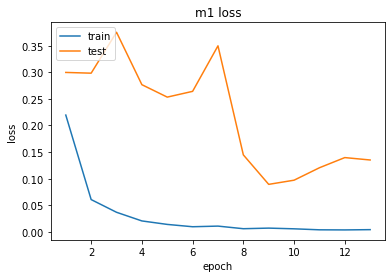

In [26]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('m1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
loaded_model = load_model('best_model_eg.h5')
loaded_model.evaluate(test_inputs,test_outputs)[1]

48/48 [==============================] - 3s 27ms/step - loss: 0.0706 - acc: 0.9808


0.9808327555656433

In [28]:
def 문장_전처리(문장):
    문장 = preprocessing(X_text=문장, remove_stopwords=True)
    encoded = token.texts_to_sequences([문장])
    pad_new = pad_sequences(encoded, maxlen = w_l) 
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print(f"{score * 100:.2f}% 확률로 스팸입니다.\n")
    else:
        print(f"{(1 - score) * 100:.2f}% 확률로 정상메일 입니다.\n")

In [29]:
문장_전처리("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's")

99.91% 확률로 스팸입니다.



In [30]:
문장_전처리('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

99.94% 확률로 정상메일 입니다.



In [31]:
loaded_model.layers

In [32]:
loaded_model.layers[0]

In [33]:
len(loaded_model.layers[0].get_weights())

1

In [34]:
len(loaded_model.layers[0].get_weights()[0])

984

In [35]:
len(loaded_model.layers[0].get_weights()[0][1])

100

In [48]:
d=token.word_counts.items()
d

odict_items([('ok', 144), ('tell', 74), ('half', 27), ('hr', 7), ('b', 57), ('u', 632), ('come', 129), ('need', 90), ('prepare', 3), ('polyphonic', 4), ('tone', 31), ('ur', 188), ('mob', 11), ('every', 46), ('week', 68), ('txt', 88), ('pt', 1), ('st', 21), ('free', 137), ('get', 196), ('txtin', 2), ('friends', 25), ('p', 95), ('reply', 72), ('hl', 10), ('info', 9), ('bag', 4), ('born', 3), ('god', 22), ('said', 44), ('oh', 57), ('another', 23), ('idiot', 2), ('funny', 6), ('fact', 5), ('nobody', 5), ('teaches', 4), ('volcanoes', 1), ('erupt', 1), ('tsunamis', 1), ('arise', 1), ('hurricanes', 1), ('sway', 1), ('aroundn', 1), ('hw', 5), ('choose', 7), ('wife', 10), ('natural', 3), ('disasters', 1), ('happens', 6), ('cooked', 2), ('rather', 4), ('nice', 29), ('salmon', 1), ('la', 6), ('text', 91), ('messages', 13), ('valid', 15), ('december', 2), ('love', 114), ('someone', 35), ('dont', 80), ('make', 55), ('much', 60), ('want', 105), ('loved', 9), ('anyone', 7), ('except', 2), ('gud', 25)

In [37]:
for w,i in token.word_counts.items():
    print(w)
    print(i)
    break

ok
144


In [39]:
pr_data=sorted(d, key=lambda x:x[1])

In [40]:
for w,i in pr_data:
    print(w)
    print(i)
    break

pt
1


In [43]:
len(pr_data)

5401

In [42]:
len(token.word_index)

5401

In [47]:
token.word_index#많이 나온순

{'u': 1,
 'call': 2,
 'get': 3,
 'ur': 4,
 'go': 5,
 'know': 6,
 'ok': 7,
 'free': 8,
 'got': 9,
 'come': 10,
 'like': 11,
 'good': 12,
 'day': 13,
 'love': 14,
 'want': 15,
 'time': 16,
 'going': 17,
 'one': 18,
 'p': 19,
 'lor': 20,
 'text': 21,
 'send': 22,
 'need': 23,
 'still': 24,
 'r': 25,
 'txt': 26,
 'k': 27,
 'back': 28,
 'stop': 29,
 'see': 30,
 'home': 31,
 'dont': 32,
 'da': 33,
 'n': 34,
 'tell': 35,
 'new': 36,
 'reply': 37,
 'today': 38,
 'take': 39,
 'night': 40,
 'think': 41,
 'week': 42,
 'c': 43,
 'phone': 44,
 'hi': 45,
 'sorry': 46,
 'happy': 47,
 'hey': 48,
 'please': 49,
 'much': 50,
 'great': 51,
 'number': 52,
 'pls': 53,
 'hope': 54,
 'well': 55,
 'b': 56,
 'oh': 57,
 'give': 58,
 'make': 59,
 'msg': 60,
 'already': 61,
 'mobile': 62,
 'way': 63,
 'ask': 64,
 'dear': 65,
 'later': 66,
 'claim': 67,
 'e': 68,
 'wat': 69,
 'thanks': 70,
 'work': 71,
 'say': 72,
 'tomorrow': 73,
 'www': 74,
 'prize': 75,
 'im': 76,
 'every': 77,
 'really': 78,
 'find': 79,
 'las

In [50]:
list(token.word_index.keys())

['u',
 'call',
 'get',
 'ur',
 'go',
 'know',
 'ok',
 'free',
 'got',
 'come',
 'like',
 'good',
 'day',
 'love',
 'want',
 'time',
 'going',
 'one',
 'p',
 'lor',
 'text',
 'send',
 'need',
 'still',
 'r',
 'txt',
 'k',
 'back',
 'stop',
 'see',
 'home',
 'dont',
 'da',
 'n',
 'tell',
 'new',
 'reply',
 'today',
 'take',
 'night',
 'think',
 'week',
 'c',
 'phone',
 'hi',
 'sorry',
 'happy',
 'hey',
 'please',
 'much',
 'great',
 'number',
 'pls',
 'hope',
 'well',
 'b',
 'oh',
 'give',
 'make',
 'msg',
 'already',
 'mobile',
 'way',
 'ask',
 'dear',
 'later',
 'claim',
 'e',
 'wat',
 'thanks',
 'work',
 'say',
 'tomorrow',
 'www',
 'prize',
 'im',
 'every',
 'really',
 'find',
 'last',
 'yeah',
 'anything',
 'cash',
 'said',
 'let',
 'lol',
 'miss',
 'message',
 'yes',
 'right',
 'would',
 'next',
 'meet',
 'money',
 'wait',
 'something',
 'life',
 'cos',
 'babe',
 'uk',
 'us',
 'com',
 'morning',
 'win',
 'soon',
 'gonna',
 'could',
 'contact',
 'min',
 'someone',
 'care',
 'around'

In [49]:
w_l_data=list(token.word_index.keys())

In [51]:
w_l_data.insert(0,'OOV')

In [52]:
w_l_data

['OOV',
 'u',
 'call',
 'get',
 'ur',
 'go',
 'know',
 'ok',
 'free',
 'got',
 'come',
 'like',
 'good',
 'day',
 'love',
 'want',
 'time',
 'going',
 'one',
 'p',
 'lor',
 'text',
 'send',
 'need',
 'still',
 'r',
 'txt',
 'k',
 'back',
 'stop',
 'see',
 'home',
 'dont',
 'da',
 'n',
 'tell',
 'new',
 'reply',
 'today',
 'take',
 'night',
 'think',
 'week',
 'c',
 'phone',
 'hi',
 'sorry',
 'happy',
 'hey',
 'please',
 'much',
 'great',
 'number',
 'pls',
 'hope',
 'well',
 'b',
 'oh',
 'give',
 'make',
 'msg',
 'already',
 'mobile',
 'way',
 'ask',
 'dear',
 'later',
 'claim',
 'e',
 'wat',
 'thanks',
 'work',
 'say',
 'tomorrow',
 'www',
 'prize',
 'im',
 'every',
 'really',
 'find',
 'last',
 'yeah',
 'anything',
 'cash',
 'said',
 'let',
 'lol',
 'miss',
 'message',
 'yes',
 'right',
 'would',
 'next',
 'meet',
 'money',
 'wait',
 'something',
 'life',
 'cos',
 'babe',
 'uk',
 'us',
 'com',
 'morning',
 'win',
 'soon',
 'gonna',
 'could',
 'contact',
 'min',
 'someone',
 'care',
 

In [53]:
ws=loaded_model.layers[0].get_weights()[0]

In [56]:
len(ws),len(w_l_data)

(984, 5402)

In [59]:
w_l_data=w_l_data[:984]

In [60]:
len(ws),len(w_l_data)

(984, 984)

In [61]:
import io#인풋 아웃풋 클래스 불러온다.
out_v = io.open('v_data.tsv','w',encoding='utf-8')#백터값 내보내기위한 객체
out_w = io.open('w_data.tsv','w',encoding='utf-8')

for i, w in enumerate(w_l_data):
    if i == 0 :
        continue
    vec=ws[i]
    out_v.write('\t'.join([str(i) for i in vec])+'\n')#글자로 입력할것이기 때문에 숫자값을 문자로 변형 +'\n':다음줄내리기
    out_w.write(w+'\n')
out_v.close()
out_w.close()